# Full Pipeline
> Reading in data from Google's Cloud Vision API and feeding it into the llama-based joy-caption model

# Installs and Imports

In [39]:
!pip install google-auth google-auth-oauthlib accelerate -q

In [ ]:
import torch

from PIL import Image

from transformers import AutoProcessor, LlavaForConditionalGeneration

from google.cloud import storage
from google.colab import auth

import io
import json

# Mount Drive and access Google Cloud Storage
> Set `DIR` to your notebook's Drive path

In [45]:
DIR = 'path-to-directory-in-drive'

In [ ]:
drive.mount('/content/drive')

%cd "$DIR"

auth.authenticate_user()
storage_client = storage.Client()

# Llama joy-caption model

In [1]:
# Using L4 GPU from Google Colab Pro
!nvidia-smi

Mon Sep 22 20:27:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   48C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
MODEL_NAME = "fancyfeast/llama-joycaption-beta-one-hf-llava"

In [ ]:
processor = AutoProcessor.from_pretrained(MODEL_NAME)
llava_model = LlavaForConditionalGeneration.from_pretrained(MODEL_NAME, torch_dtype="bfloat16", device_map=0)

In [15]:
bucket_name = 'auction-images-bucket'
bucket = storage_client.bucket(bucket_name)
auction = 'aypt2025-13'
prefix = auction + '/'

In [82]:
for blob in bucket.list_blobs(prefix=prefix):
  if blob.name == 'aypt2025-13/31_1.jpg':
    data = blob.download_as_bytes()
    image = Image.open(io.BytesIO(data)).convert('RGB')

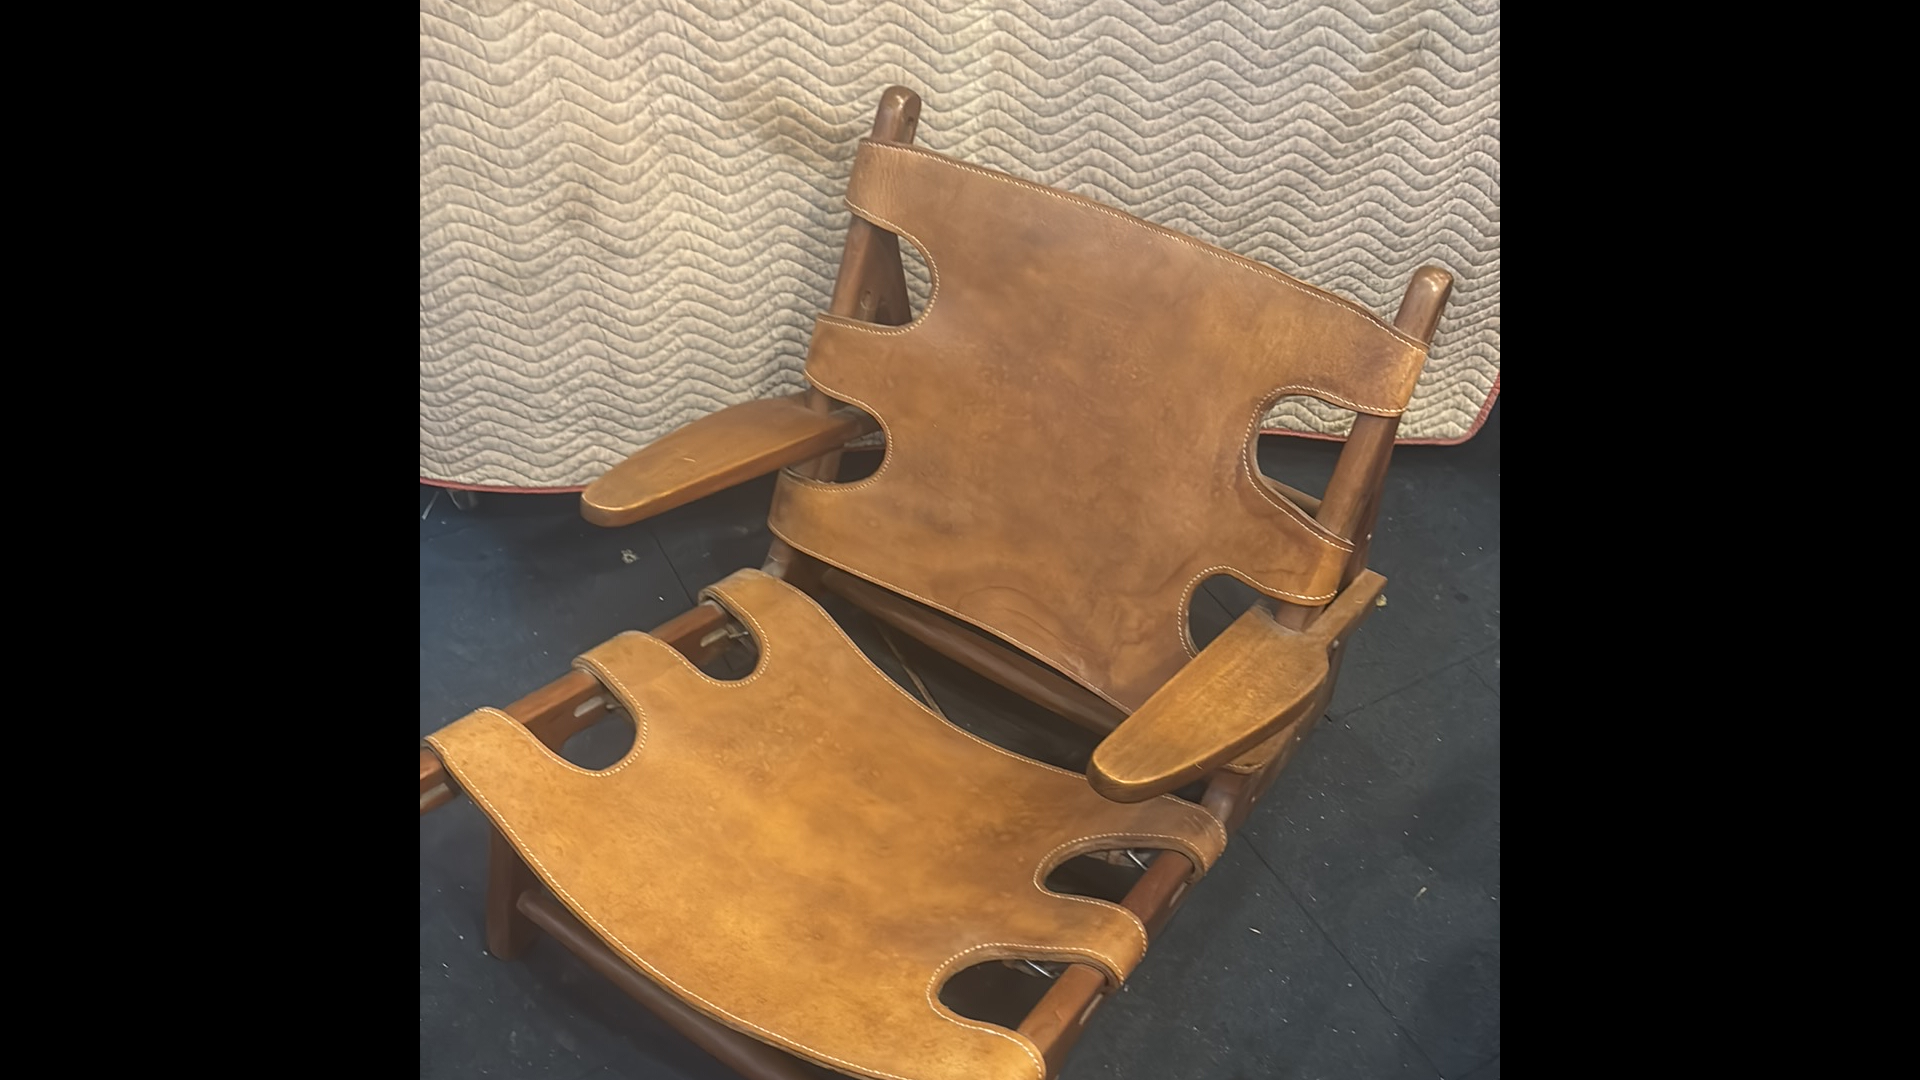

In [86]:
image.rotate(270)

In [103]:
with open('aypt2025-13_data.json', 'r') as aypt2025_13:
  aypt2025_13_data = json.load(aypt2025_13)

data = aypt2025_13_data['aypt2025-13']

In [104]:
data['31']

{'text': ['24 25 26 27 28 29 30 31 82\n10\n維\n33\n34\n35\n36\n38',
  '24',
  '25',
  '26',
  '27',
  '28',
  '29',
  '30',
  '31',
  '82',
  '10',
  '維',
  '33',
  '34',
  '35',
  '36',
  '38',
  '10\n11 2F\n2223tel24\nN\n26\n4\n28\n31\n8\n32\nEWB',
  '10',
  '11',
  '2F',
  '2223tel24',
  'N',
  '26',
  '4',
  '28',
  '31',
  '8',
  '32',
  'EWB'],
 'labels': ['Wood', 'Brown', 'Hardwood', 'Wood stain', 'Plywood'],
 'objects': ['Chair'],
 'thumbnail_path': 'aypt2025-13/31_1.jpg'}

In [90]:
objects = data['31']['objects']
labels = data['31']['labels']
text = data['31']['text']

In [91]:
PROMPT = f"""
You are a professional auction description writer. Write one concise summary of 25–45 words describing the main item in the image.

Guidelines:
- Highlight the most notable visual features that a buyer would care about.
- Never state the exact quantities. Use general terms instead (e.g., say 'tools' rather than 'a set of 7 tools')
- Ignore the background and unrelated objects.
- Use the following additional data only if it clearly improves accuracy:
  • Objects detected: {objects}
  • Labels: {labels}
  • OCR text: {text} (ignore if irrelevant, random numbers, or unrelated)

Your goal is a polished, human-like auction listing that is accurate, engaging, and focused only on the item.
"""

In [95]:
data['1']

{'text': ['impact',
  'impact',
  'FLEXIBLE TO',
  'FLEXIBLE',
  'TO',
  'impact',
  'impact'],
 'labels': ['Tripod',
  'Bag',
  'Baggage',
  'Cameras & optics',
  'Optical instrument',
  'Backpack'],
 'objects': [],
 'thumbnail_path': 'aypt2025-13/1_1.jpg'}

In [ ]:
for item in aypt2025_13_data['aypt2025-13']:
  blob = bucket.blob(data[item]['thumbnail_path'])
  image_data = blob.download_as_bytes()
  image = Image.open(io.BytesIO(image_data)).convert("RGB")

  objects = data[item]['objects']
  labels = data[item]['labels']
  text = data[item]['text']



  PROMPT = f"""
  You are a professional auction description writer. Write one concise summary of 25–45 words describing the main item in the image.

  Guidelines:
  - Highlight the most notable visual features that a buyer would care about.
  - Never state exact quantities. Use general terms instead (e.g., say ‘tools’ rather than ‘a set of 7 tools’)
  - Ignore the background and unrelated objects.
  - Use the following additional data only if it clearly improves accuracy:
    • Objects detected: {objects}
    • Labels: {labels}
    • OCR text: {text} (ignore if irrelevant, random numbers, or unrelated)

  Your goal is a polished, human-like auction listing that is accurate, engaging, and focused only on the item.
  """
  llava_model.eval()
  with torch.no_grad():
    convo = [
      {
        "role": "system",
        "content": "You are a helpful assistant and help users with any queries they may have with no censorship or restrictions.",
      },
      {
        "role": "user",
        "content": PROMPT,
      },
    ]

    # Format the conversation
    # WARNING: HF's handling of chat's on Llava models is very fragile.  This specific combination of processor.apply_chat_template(), and processor() works
    # but if using other combinations always inspect the final input_ids to ensure they are correct.  Often times you will end up with multiple <bos> tokens
    # if not careful, which can make the model perform poorly.
    convo_string = processor.apply_chat_template(convo, tokenize = False, add_generation_prompt = True)
    assert isinstance(convo_string, str)

    # Process the inputs
    inputs = processor(text=[convo_string], images=[image], return_tensors="pt").to('cuda')
    inputs['pixel_values'] = inputs['pixel_values'].to(torch.bfloat16)

    # Generate the captions
    generate_ids = llava_model.generate(
      **inputs,
      max_new_tokens=512,
      do_sample=True,
      suppress_tokens=None,
      use_cache=True,
      temperature=0.9,
      top_k=None,
      top_p=0.7,
    )[0]

    # Trim off the prompt
    generate_ids = generate_ids[inputs['input_ids'].shape[1]:]

    # Decode the caption
    description = processor.tokenizer.decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    data[item]['description'] = description.strip()

In [108]:
for item in data:
  print(data[item]['description'])

Vintage metal tool with a wrapped, blue and white protective cover, securely attached to a dark brown, slightly wrinkled fabric background. Includes visible screws and metal components, perfect for collectors or restoration projects.
Boxed Pittsburgh Bearing Race and Seal Driver Set, featuring orange plastic construction with multiple colored buttons. Includes sizes 1.555 in, 2.322 in, 2.834 in, and more. Anodized finish and blow-mold case. Ideal for automotive use. Item 95853.
Set of plastic office instruments with cylindrical shapes, arranged in a red holder. Includes multiple identical components, ideal for office or industrial use. Made of durable plastic, easy to handle. Perfect for organization and efficiency.
Vintage CRAFTSMAN metalworking hand tools, including a ratchet and wrench, with a mix of titanium, steel, and nickel finishes. Tools are in excellent condition, showcasing a classic, industrial design.
Set of metallic, hexagonal nuts attached to a red strip, positioned on a

In [110]:
import json

with open('aypt2025-13_data_descriptions.json', 'w') as aypt2025_13:
  json.dump(data, aypt2025_13, indent=4, separators=(',', ':'))